# Predict TripAdvisor Rating

В [этом соревновании](https://www.kaggle.com/c/sf-dst-restaurant-rating/leaderboard) нам предстоит предсказать рейтинг ресторана в TripAdvisor


По ходу задачи:
* Просмотрим данные, которые предоставили
* Сделаем предобработку 
* Поработаем с пропущенными данными (Nan)
* Сгенерируем новые признаки (Feature Engineering) разными способами
* Создадим простую модель для предсказания рейтинга ресторана

По условия соревнования нельзя удалять строки-объекты. Код для построения модели предоставляется создателями соревнования - все участники должны использовать только его. т. е. главная работы построена на EDA и Feature Engineering.

# import

In [1]:
# Импортируем необходимые модули
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from textblob import TextBlob  # Библиотека для определения тональности отзывов
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Настройки для более комфортного отображения таблиц
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)

# Просмотр файлов в директории
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы для всех!
RANDOM_SEED = 42

# Дополнительные функции для удобства дальнейшей работы

In [3]:
def creatre_columns_NAN(data, list_columns):
    """На вход подаётся список колонок и ДФ, для которых создаются новые колонки с нулями и единицами,
    где 1 - в месте пропуска"""
    data_Nan = pd.DataFrame()
    for i in list_columns:
        data_Nan[i+'_is_NAN'] = pd.isna(data[i]).astype('uint8')
    return data_Nan

In [4]:
def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и 
    считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc25),
        '75-й перцентиль: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))

# Обзор данных

Открываем файлы, смотрим что из себя представляют

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города (ранг);
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [6]:
df_train.info()
display(df_train.sample(3))
print("Размер датасета для обучения: {}".format(df_train.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
24933,id_2820,Barcelona,['Spanish'],2821.0,4.0,$$ - $$$,107.0,"[['Good service and excellent food'], ['11/14/2015']]",/Restaurant_Review-g187497-d4103144-Reviews-El_Raco_de_l_Avi_Melcior-Barcelona_Catalonia.html,d4103144
35445,id_361,Paris,"['French', 'European', 'Vegetarian Friendly']",362.0,4.5,$$ - $$$,277.0,"[['Quality food, great presentation and well...', 'Nice change for a Bistro'], ['07/31/2017', '05/06/2017']]",/Restaurant_Review-g187147-d2723844-Reviews-Tempero-Paris_Ile_de_France.html,d2723844
12926,id_1698,Rome,"['Italian', 'Fast Food', 'European', 'Vegetarian Friendly', 'Vegan Options']",1699.0,4.5,$$ - $$$,209.0,"[['Neighborhood Gem', 'Awesome Food and Friends Over the Counter'], ['10/16/2017', '09/11/2017']]",/Restaurant_Review-g187791-d6957280-Reviews-Eat_Street_Food-Rome_Lazio.html,d6957280


Размер датасета для обучения: (40000, 10)


In [7]:
df_test.info()
display(df_test.sample(3))
print("Размер датасета для сабмита: {}".format(df_test.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
3184,id_3184,Rome,"['Italian', 'Pizza', 'Seafood', 'Mediterranean', 'Barbecue', 'European', 'Vegetarian Friendly', 'Vegan Options', 'Gl...",774.0,$$ - $$$,893.0,"[['Waterfront experience', 'Excellent location'], ['01/04/2018', '07/17/2017']]",/Restaurant_Review-g187791-d1641052-Reviews-Cuccurucu-Rome_Lazio.html,d1641052
8711,id_8711,Hamburg,NaN,2407.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187331-d5608387-Reviews-Schmitt_Foxy_Food-Hamburg.html,d5608387
1914,id_1914,Barcelona,NaN,7479.0,NaN,2.0,"[['Friendly spot with good food'], ['12/28/2016']]",/Restaurant_Review-g187497-d11903522-Reviews-Vins_Bens-Barcelona_Catalonia.html,d11903522


Размер датасета для сабмита: (10000, 9)


In [8]:
sample_submission.info()
sample_submission.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


Имеем два датасета: обучающий и тестовый. Для объектов первого известна целевая переменная (рейтинг ресторанов). На основаyии обущающего датасета (df_train) необходимо создать модель и предсказать значение рейтинга ресторана для объектов из тестового датасета (df_test). 
sample_submission - это пример того, как должен выглядеть итоговый ответ, который необходимо загрузить на Kaggle. 
В качестве оценки качества модели используется MAE (средняя абсолютная ошибка), т.е. в результате работы необходимо получить как более низкое значение

In [9]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['Rating'] = 0  # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [10]:
data.info()
display(data.sample(3))
print("Размер общего датасета: {}".format(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
17037,id_2772,Lisbon,NaN,2775.0,NaN,3.0,"[['Chinese food in Lisbon?'], ['04/23/2016']]",/Restaurant_Review-g189158-d10150006-Reviews-Yang-Lisbon_Lisbon_District_Central_Portugal.html,d10150006,1,4.5
48431,id_3958,Rome,"['Cafe', 'Italian', 'Vegetarian Friendly', 'Vegan Options']",3959.0,$$ - $$$,120.0,"[['Enjoy Easter Brunch Here', ""It's all about the location""], ['12/29/2017', '08/28/2017']]",/Restaurant_Review-g187791-d7134596-Reviews-Cafe_Doney-Rome_Lazio.html,d7134596,1,3.5
38208,id_1329,Brussels,['Chinese'],1330.0,$,11.0,"[['Not really authentic'], ['01/11/2017']]",/Restaurant_Review-g188644-d946770-Reviews-Aux_Delices_de_Chine-Brussels.html,d946770,1,4.0


Размер общего датасета: (50000, 11)


Большинство признаков у нас требует очистки и предварительной обработки.

# Обработка и анализ (EDA)

## Обработка NAN 

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
Поэтому перед обработкой NAN лучше вынесем информацию о наличии пропуска как отдельный признак 

Дубликатов найдено: 0
Пропусков найдено: 32153


<AxesSubplot:>

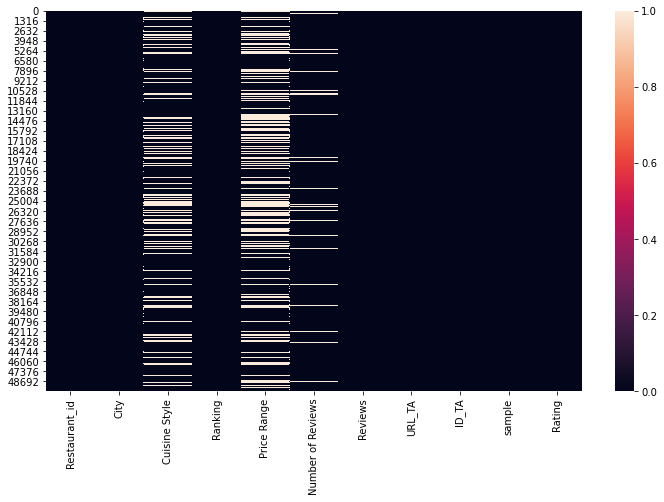

In [11]:
# Проверяем, где есть пропуски и дубликаты
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())

# "Матрица" с пропусками для наглядной оценки
plt.subplots(figsize=(12, 7))
sns.heatmap(data.isnull())

In [12]:
# Cоздаём список колонок, для которых сделаем другие колонки, отмечающие места пропусков
list_columns_with_Nan = ['Number of Reviews',
                         'Cuisine Style', 'Price Range', 'Reviews']

# Сохраним их в отдельный ДФ, который присоединим к data перед моделированием
columns_NAN = creatre_columns_NAN(data, list_columns_with_Nan)
columns_NAN

,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Reviews_is_NAN
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
49995,0,0,0,0
49996,0,0,0,0
49997,0,0,1,0
49998,0,0,0,0


Обрабатывать пропуски будем "индивидуально" для каждого столбца. 
Сейчас отдельно изучим каждый признак. 

Колонки Restaurant_id и URL_TA не информативны, поэтому можно сразу удалить эти признаки

In [13]:
data.drop(['Restaurant_id', 'URL_TA'], axis = 1, inplace=True)  

## ID_TA

In [14]:
data['ID_TA'].sample(5)

38823    d11814231
44258     d1501845
7155       d734115
896       d3626343
4282      d1106544
Name: ID_TA, dtype: object

Не до конца ясно, что за идентификатор. Удалять пока не будем

In [15]:
# Удалим символ "d" из признака ID_TA
data['ID_TA'] = data['ID_TA'].apply(lambda x:x[1:])

## City

Text(0, 0.5, 'Город')

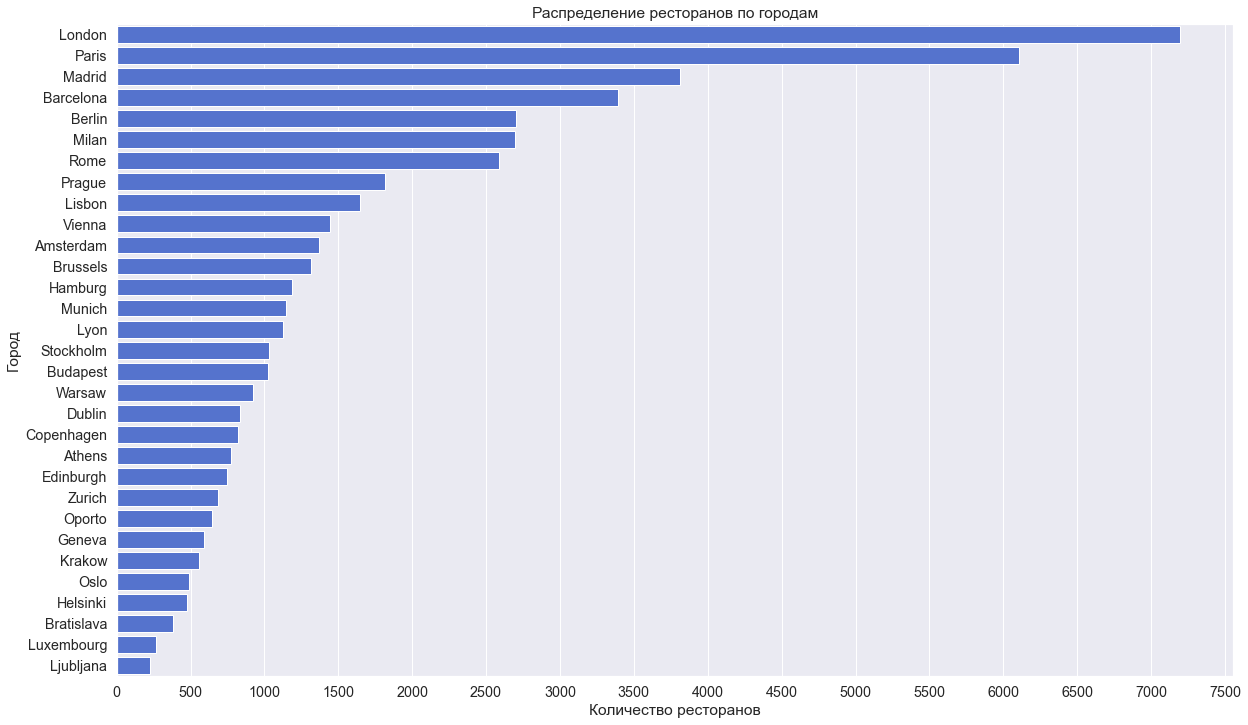

In [16]:
# Посмотрим на распределение ресторанов по городам
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 12))
plt.xticks(ticks=range(0, 7501, 500))
plt.title('Распределение ресторанов по городам')
sns.countplot(y="City",
              data=data,
              order=data.City.value_counts().index,
              color='royalblue')
plt.xlabel('Количество ресторанов')
plt.ylabel('Город')

Всего 31 город. В дальнейшем добавим данные по населению и площади этих городов. Сгруппируем данные по городам, для дальнейшей обработки пропусков

In [17]:
# Создадим таблицы по городам со средними и медианными значениями для дальнейшей замены пропусков
data_city_mean = data.groupby('City').mean().round()
#data_city_median = data.groupby('City').median()
data_city_max = data.groupby('City').max(1)
data_city_mean

,Ranking,Number of Reviews,sample,Rating
City,,,,
Amsterdam,1592.0,149.0,1.0,3.0
Athens,880.0,94.0,1.0,3.0
Barcelona,3879.0,136.0,1.0,3.0
Berlin,3255.0,64.0,1.0,3.0
Bratislava,462.0,52.0,1.0,3.0
Brussels,1542.0,93.0,1.0,3.0
Budapest,1219.0,159.0,1.0,3.0
Copenhagen,982.0,95.0,1.0,3.0
Dublin,972.0,154.0,1.0,3.0


## Cuisine Style

In [18]:
data['Cuisine Style'].sample(5)

46664       ['French', 'European']
42085    ['Caribbean', 'Jamaican']
27784                   ['French']
19579                      ['Pub']
4927                           NaN
Name: Cuisine Style, dtype: object

Значения в колонке представляют собой строки, в которых в квадратный скобках через запятую представлены виды кухонь в ресторане. 
Удалим скобки и кавычки, которые кое-где встречаются. Разобъем строку по запятым в список и посчитаем его длину - это и будет количество кухонь в ресторане. Если нет данных, то предположим, что в данном ресторане представлен только один вид

In [19]:
data['Cuisine Style'].fillna('[]', inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').replace(' ', '').replace('"', ''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(','))
data['Number_of_kitchen'] = data['Cuisine Style'].apply(lambda x: len(x))

# Посмотрим на IQR-статистику
IQR_for_column('Number_of_kitchen')

25-й перцентиль: 1.0 | 75-й перцентиль: 4.0 | IQR: 3.0 |  Границы выбросов: [-3.5, 8.5].
Выбросов, согласно IQR: 126 | 0.25%


<AxesSubplot:title={'center':'Распределение количества представленных кухонь'}, xlabel='Количество кухонь', ylabel='Чисто ресторанов'>

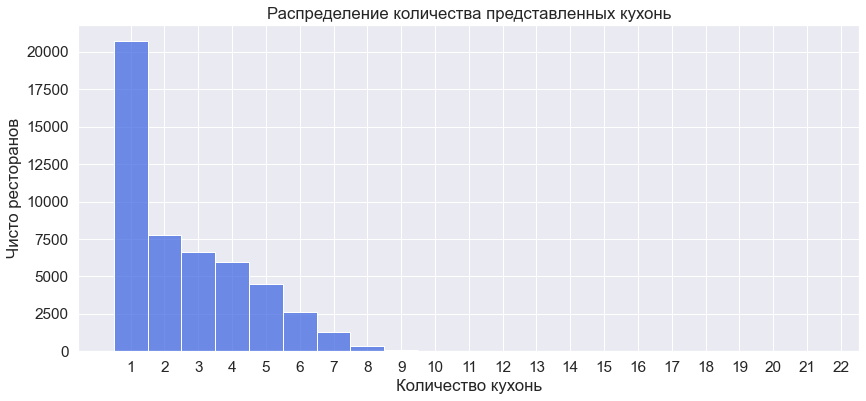

In [20]:
sns.set(font_scale=1.4)
plt.figure(figsize=(14, 6))
plt.xticks(ticks=range(1, 25, 1))
plt.title('Распределение количества представленных кухонь')
plt.xlabel('Количество кухонь')
plt.ylabel('Чисто ресторанов')
sns.histplot(data['Number_of_kitchen'], discrete=True, color='royalblue')

<AxesSubplot:title={'center':'Распределение количества представленных кухонь > 8'}, xlabel='Количество кухонь', ylabel='Чисто ресторанов'>

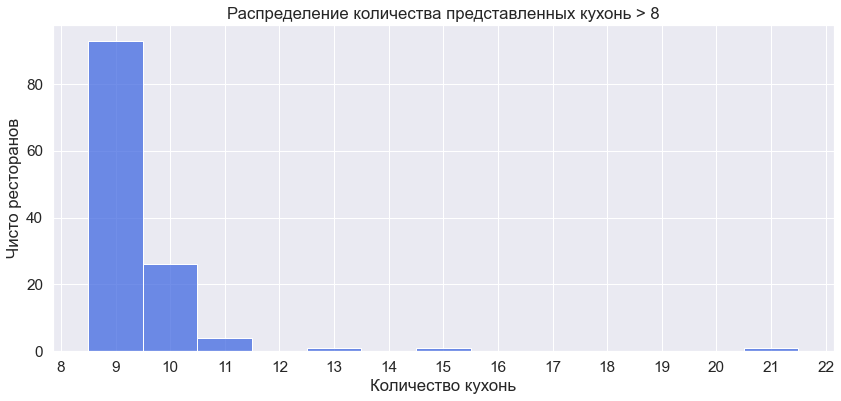

In [21]:
# Посмотрим внимательнее на количество ресторанов, в которых представленных кухонь больше восьми
sns.set(font_scale=1.4)
plt.figure(figsize=(14, 6))
plt.xticks(ticks=range(1, 25, 1))
plt.title('Распределение количества представленных кухонь > 8')
plt.xlabel('Количество кухонь')
plt.ylabel('Чисто ресторанов')
sns.histplot(data[data['Number_of_kitchen']>=9]['Number_of_kitchen'], discrete=True, color='royalblue')

Согласно IQR в данных есть 126 выбросов (кухонь больше восьми), однако при более детальном рассмотрений значений я не могу отнести их к выбросам

## Price Range

In [22]:
print('Всего у {} ресторанов ({:.2%}) не указана ценовая категория'.format(
    data['Price Range'].isnull().sum(), 
    data['Price Range'].isnull().sum()/len(data)))

Всего у 17361 ресторанов (34.72%) не указана ценовая категория


In [23]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Заменим значения на 1, 2 или 3 соотвественно. Посмотрим на средние цены по городам

In [24]:
data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

In [25]:
# Заменим пропуски на среднее значение по городам (округлим до 2 знаков после запятой)
data.loc[data['Price Range'].isnull(), 'Price Range'] = data.groupby('City').transform('mean').round(2)
data.groupby('City').mean()['Price Range']

City
Amsterdam     1.832070
Athens        1.707784
Barcelona     1.782515
Berlin        1.741656
Bratislava    1.861684
Brussels      1.859330
Budapest      1.718746
Copenhagen    1.900244
Dublin        1.788971
Edinburgh     1.710000
Geneva        2.049831
Hamburg       1.862108
Helsinki      1.868337
Krakow        1.651715
Lisbon        1.729970
Ljubljana     1.747748
London        1.809199
Luxembourg    1.979163
Lyon          1.897957
Madrid        1.849554
Milan         1.741930
Munich        1.911170
Oporto        1.669268
Oslo          1.940082
Paris         1.891197
Prague        1.740231
Rome          1.733553
Stockholm     1.941200
Vienna        1.858780
Warsaw        1.811924
Zurich        1.971693
Name: Price Range, dtype: float64

Text(0, 0.5, 'Ценовая категория')

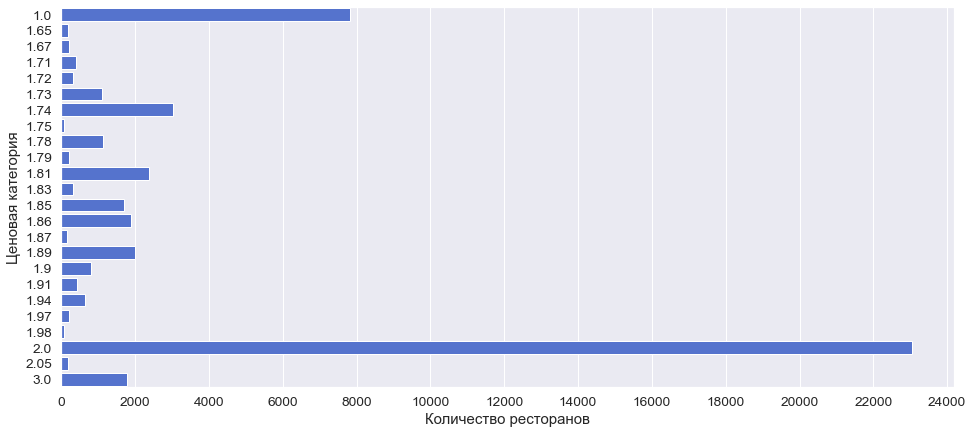

In [26]:
# Посмотрим на распределение ресторанов по цене
sns.set(font_scale=1.25)
plt.figure(figsize=(16, 7))
plt.xticks(ticks=range(0, 30000, 2000))
sns.countplot(y=data['Price Range'], color='royalblue', orient='v')
plt.xlabel('Количество ресторанов')
plt.ylabel('Ценовая категория')

## Ranking

Text(0, 0.5, 'Количество ресторанов')

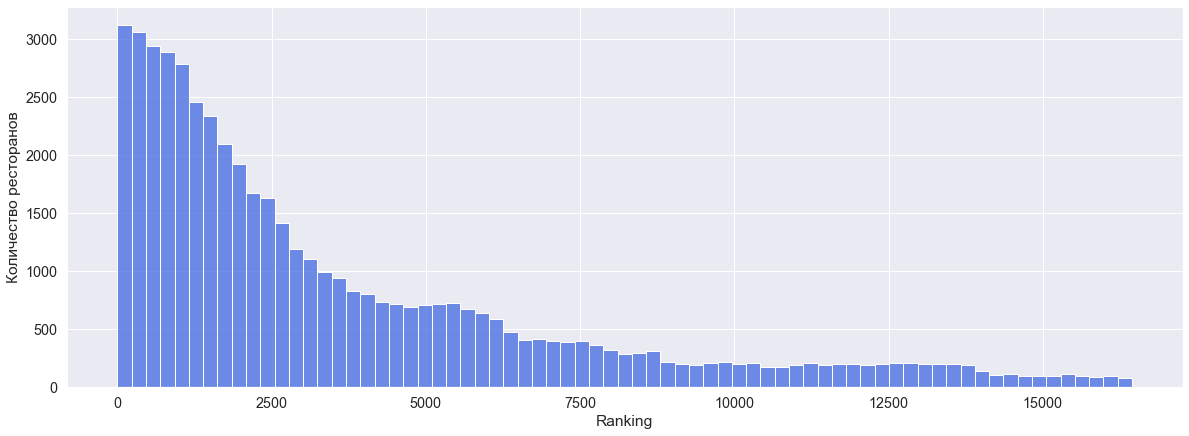

In [27]:
# Посмотрим распредение ресторанов по рангу
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['Ranking'], color='royalblue')
plt.ylabel('Количество ресторанов')

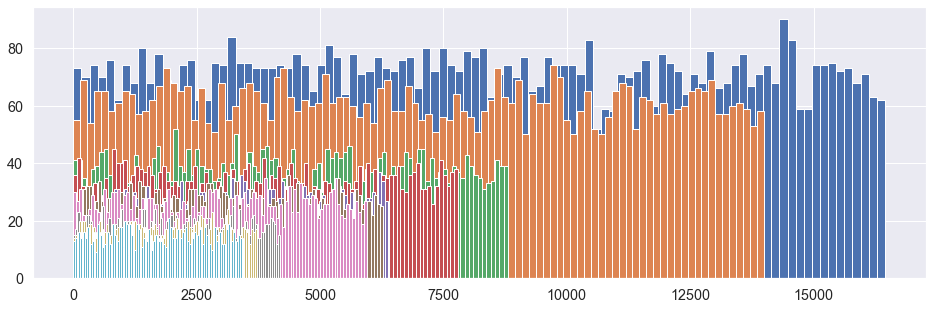

In [28]:
# Посмотрим на данные по Ranking топ 10-ти городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100, figsize=(16,5))

В больших городах больше ресторанов, значит Ranking у некоторых может быть очень высокий. 
Нужно нормировать значения по городам, чтобы при обучении модели не было ошибок. 

In [29]:
# Создаём колонку с нормированным по городам рангом ресторанов
data['Ranking_NORM'] = data[['City', 'Ranking']].apply(
    lambda x: x[1]/data_city_max.Ranking[x[0]], axis=1)

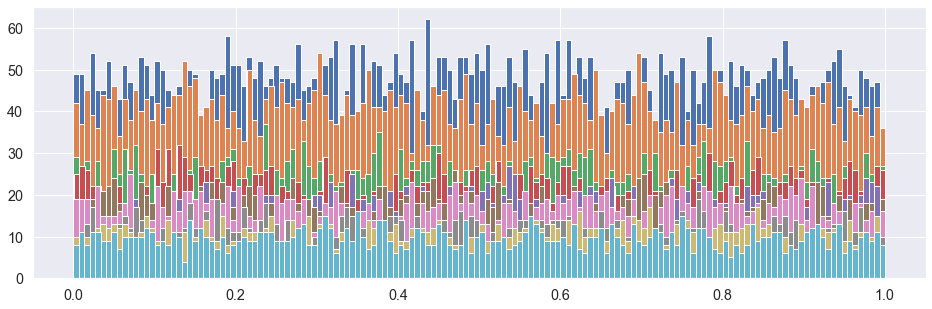

In [30]:
# Данные по нормированному Ranking топ 10-ти городов
for x in (df_train['City'].value_counts())[0:10].index:
    data['Ranking_NORM'][data['City'] == x].hist(bins=150, figsize=(16, 5))

## Number of Reviews

In [31]:
print('Количество пропусков в колонке Number of Reviews: {}'.format(
    data['Number of Reviews'].isnull().sum()))

Количество пропусков в колонке Number of Reviews: 3200


25-й перцентиль: 10.0 | 75-й перцентиль: 124.0 | IQR: 114.0 |  Границы выбросов: [-161.0, 295.0].
Выбросов, согласно IQR: 5039 | 10.08%


Text(0, 0.5, 'Количество ресторанов')

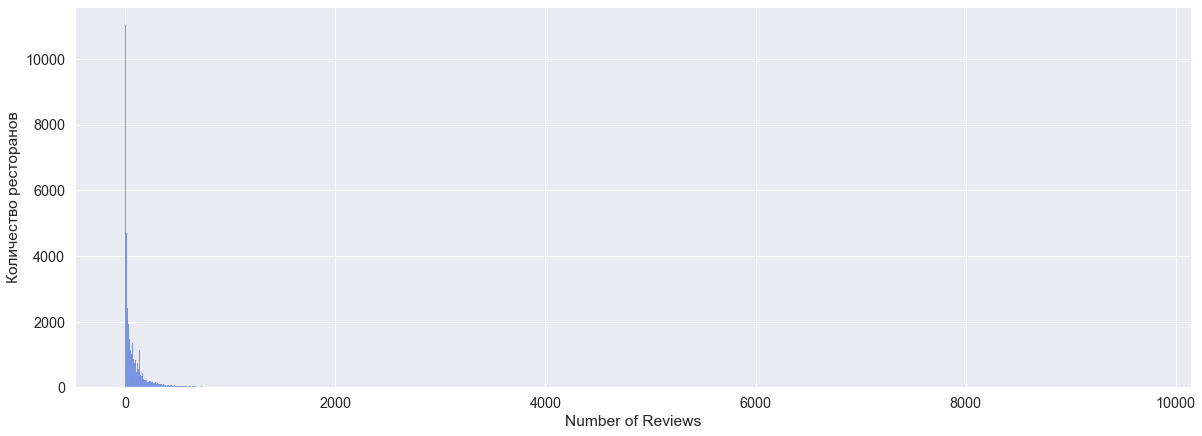

In [32]:
# Заменим на среднее количество отзывов в городе
data['Number of Reviews'] = data[['City', 'Number of Reviews']].apply(
    lambda x: data_city_mean['Number of Reviews'].to_dict()[x[0]] if pd.isna(x[1]) else x[1], axis=1)

IQR_for_column('Number of Reviews')

# Посмотрим на распределение по количеству отзывов
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['Number of Reviews'], color='royalblue')
plt.ylabel('Количество ресторанов')

Очень много низких значений. Более 10% выбросов согластно IQR. Логарифмируем данное значение, чтобы сгладить распределение и тем самым уменьшить количество аномальных значений

25-й перцентиль: 2.3978952727983707 | 75-й перцентиль: 4.8283137373023015 | IQR: 2.430418464503931 |  Границы выбросов: [-1.2477324239575256, 8.473941434058197].
Выбросов, согласно IQR: 18 | 0.04%


Text(0, 0.5, 'Количество ресторанов')

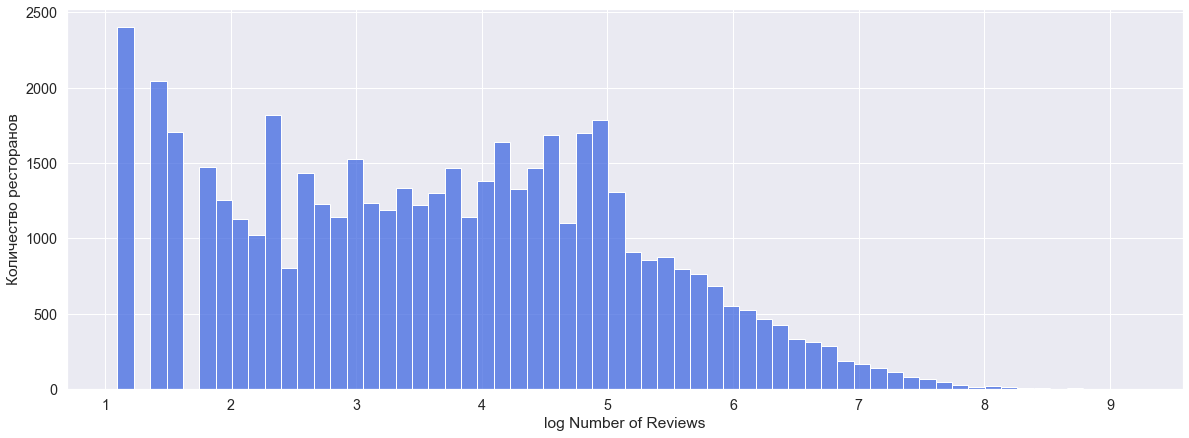

In [33]:
data['log Number of Reviews'] = np.log(data['Number of Reviews'] + 1)
IQR_for_column('log Number of Reviews')
sns.set(font_scale=1.3)
plt.subplots(figsize=(20, 7))
sns.histplot(data['log Number of Reviews'], color='royalblue')
plt.ylabel('Количество ресторанов')

Распределение заметно улучшилось, немного нормализовалось. Осталось всего 18 выбросов согласно IQR

## Reviews

Наиболее сложная колонка для обработки. Пропуски заполним '[[], []]'

Данные представлены типом str, необходимо разделить на две части - сами отзывы и даты. Эти части нужно в свою очередь разделить ещё на две части, чтобы получилось два столбца с самим текстом отзывов и два столбца с датами этих отзывов. Оставим пустые отзывы, если их нет. В дальнейшем сделаем тональный анализ. 

Из колонок с датами вытащим информацию о днях недели, месяце, разнице в днях между отзывами, а так же как давно были написаны отзывы. Все эти действия завернём в функцию, для более комфортного использования далее

In [34]:
def change_reviews(data, df_columns):
    """ Функция принимает на вход ДФ и колонку с отзывами.
    Создаёт новые колонки в ДФ:
    Review_1 - c текстом первого отзыва;
    Review_2 - с текстом второго отзыва;
    How_long_ago_1 - сколько дней назад написан первый отзыв;
    How_long_ago_2 - сколько дней назад написан второй отзыв;
    Day1_2 - разница в днях написания первого и второго отзыва;
    Day_of_week_1 - день недели написания первого отзыва;
    Day_of_week_2 - день недели написания второго отзыва;
    Month_1 - месяц написания первого отзыва;
    Month_2 - месяц написания второго отзыва"""
    df_columns.fillna('[[], []]', inplace=True)
    data['Two_reviews'] = df_columns.apply(lambda x: x.split('],')[0].split("',"))
    # Создаёт две колонки с текстами отзывов
    data['Review_1'] = data['Two_reviews'].apply(lambda x: x[0])
    data['Review_2'] = data['Two_reviews'].apply(lambda x: x[-1])
    data['Review_1'] = data['Review_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data['Review_2'] = data['Review_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data.drop('Two_reviews', axis=1, inplace=True)

    # Удалим повторы, если отзыв был один и он продублировался в столбец Review_2
    data['Review_2'] = data[['Review_2', 'Review_1']].apply(
        lambda x: '' if x[0] == x[1] else x[0], axis=1)

    # Работа с датами
    data['Days_reviews'] = df_columns.apply(
        lambda x: x.split('],')[-1].split("',"))
    data['Day_1'] = data['Days_reviews'].apply(lambda x: x[0])
    data['Day_2'] = data['Days_reviews'].apply(lambda x: x[-1])
    data['Day_1'] = data['Day_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data['Day_2'] = data['Day_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data.drop('Days_reviews', axis=1, inplace=True)

    # Удалим вторую дату (дубликат первой), если отзыв был всего один
    data['Day_2'] = data[['Day_2', 'Review_2']].apply(
        lambda x: '' if x[1] == '' else x[0], axis=1)

    # Переведём данные в формат datetime.strptime для удобства дальнейшей работы
    data['Day_1'] = data['Day_1'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))
    data['Day_2'] = data['Day_2'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))

    # Cоздаём колонки, показывающие сколько дней назад были написаны отзывы
    data['How_long_ago_1'] = (datetime.today() - data['Day_1'])
    data['How_long_ago_2'] = datetime.today() - data['Day_2']
    data['How_long_ago_1'] = data['How_long_ago_1'].apply(lambda x: x.days)
    data['How_long_ago_2'] = data['How_long_ago_2'].apply(lambda x: x.days)
    # Если пропущены значения, то заменим на среднее
    data['How_long_ago_1'].fillna(
        round(data['How_long_ago_1'].mean()), inplace=True)
    data['How_long_ago_2'].fillna(
        round(data['How_long_ago_2'].mean()), inplace=True)

    # Создаём колонку с разницей в датах отзывов
    data['Day1_2'] = abs(data['Day_1'] - data['Day_2'])
    data['Day_1'] = data['Day_1'].fillna(0)
    data['Day_2'] = data['Day_2'].fillna(0)
    data['Day1_2'] = data['Day1_2'].apply(lambda x: x.days)
    data['Day1_2'] = data['Day1_2'].fillna(0)

    # Создаём колонки с днями недели отзывов и месяцы
    data['Day_of_week_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Day_of_week_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Month_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))
    data['Month_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))

    # Удаляем больше ненужные колонки
    data.drop('Day_1', axis=1, inplace=True)
    data.drop('Day_2', axis=1, inplace=True)
    data.drop('Reviews', axis=1, inplace=True)

In [35]:
change_reviews(data, data['Reviews'])

In [36]:
data.sample(5)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
9097,Lisbon,"[European, Portuguese, VegetarianFriendly, VeganOptions]",978.0,1.00,20.0,12330127,0,0.0,4,0.263115,3.044522,Great Choice for Vegetarians/Vegans!!,Delicious!!!,1224.0,1291.0,67.0,Wednesday,Saturday,02,12
10848,Krakow,"[Bar, Pub, European, Czech, CentralEuropean]",431.0,1.00,38.0,8425435,1,4.5,5,0.346463,3.663562,Good Czech beer,Great beer at great prices,1297.0,1546.0,249.0,Sunday,Wednesday,12,03
10443,Berlin,"[International, Contemporary, Healthy]",5141.0,1.00,64.0,12098434,1,4.0,3,0.806811,4.174387,,,1510.0,1578.0,0.0,0,0,0,0
31033,London,"[Italian, Pizza, Mediterranean, European, VegetarianFriendly, GlutenFreeOptions, VeganOptions]",1365.0,2.00,48.0,12789362,1,4.5,7,0.083009,3.891820,A fantastic Italian just across the road!,A Warm welcome into an italian delight..,1276.0,1277.0,1.0,Sunday,Saturday,12,12
30553,Madrid,[FastFood],7723.0,1.85,6.0,8043490,1,3.0,1,0.876717,1.945910,,,1510.0,1578.0,0.0,0,0,0,0


Внимательнее изучим данные по датам (дням, просшедним после написания отзывов)

Text(0, 0.5, 'Прошло дней от публикации отзывов')

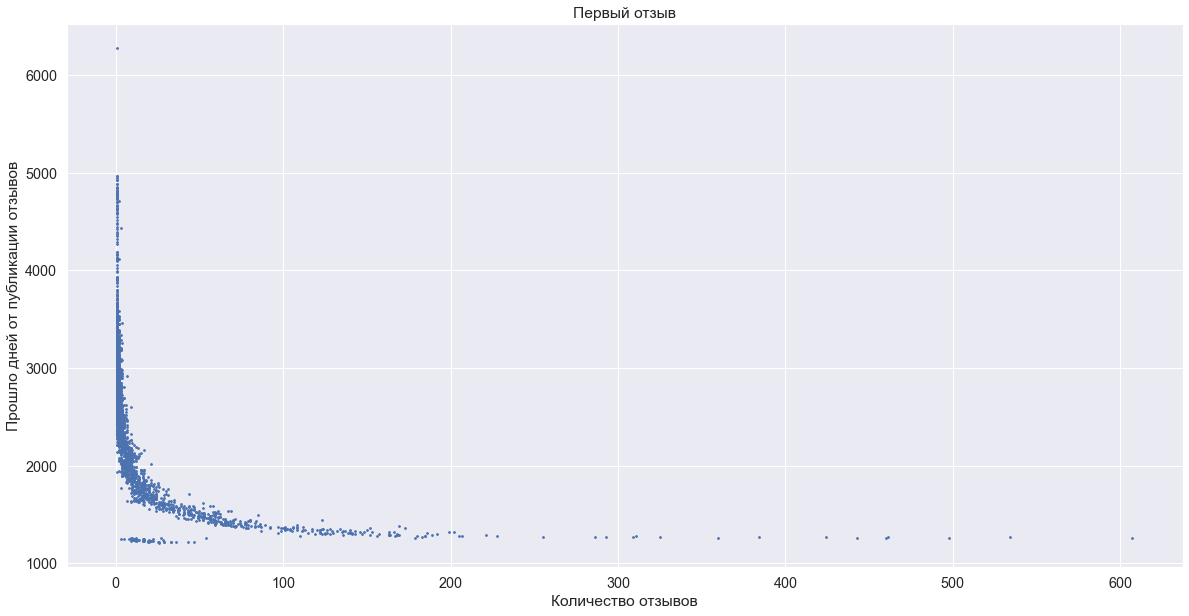

In [37]:
# Посмотроим график, где по оси y - прошедшие дни от отзыва, а по x - количество отзывов в эти дни.
# А день, когда было опубликовано наибольшее количество отзывов не будет показывать
fig, ax = plt.subplots()
x = data['How_long_ago_1'].value_counts().iloc[1:]
y = data['How_long_ago_1'].value_counts().iloc[1:].index
fig.set_figwidth(20)
fig.set_figheight(10)
ax.scatter(x, y, s = 3)
ax.set_title('Первый отзыв')
ax.set_xlabel('Количество отзывов')
ax.set_ylabel('Прошло дней от публикации отзывов')

Один день очень сильно выбивается из общей картины. Возможно ошибка в данных, и отзыв был опубликован не почти 17 лет назад. Заменим на среднее значение в столбце, а день недели на 0.

In [38]:
data[data['How_long_ago_1'] == data['How_long_ago_1'].max()]

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
47913,Vienna,"[Bar, Pub]",3137.0,1.0,2.0,694328,1,4.0,2,0.910859,1.098612,Great affordable restaurant,,6271.0,1578.0,0.0,Wednesday,0,04,0


In [39]:
data.at[47913, 'How_long_ago_1'] = data['How_long_ago_1'].mean()
data.at[47913, 'Day_of_week_1'] = 0

Text(0, 0.5, 'Прошло дней от публикации отзывов')

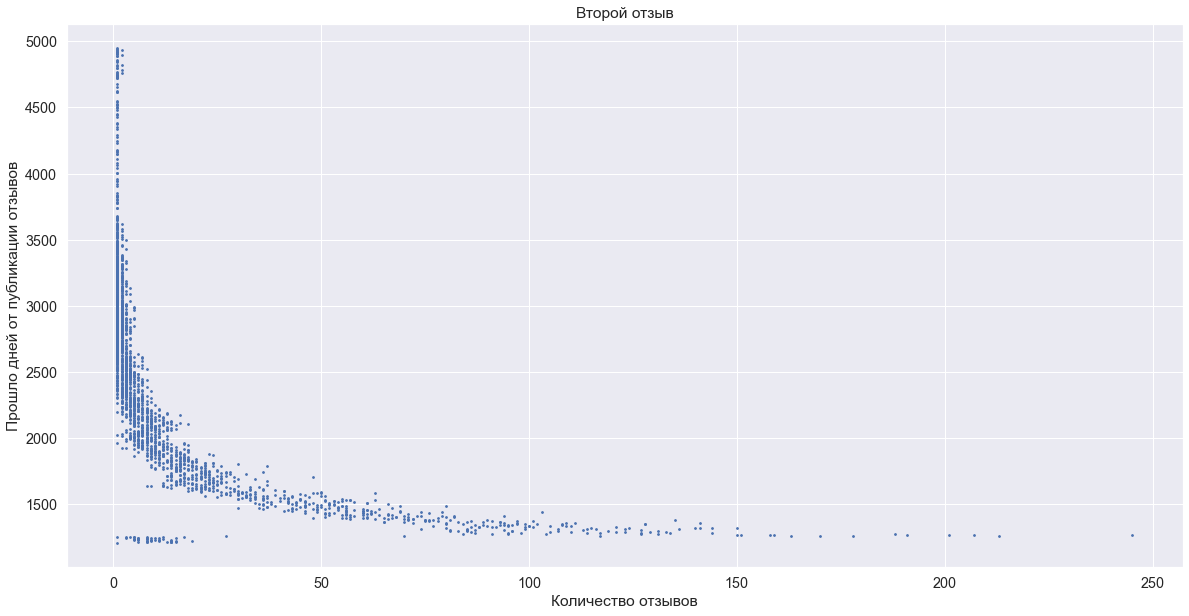

In [40]:
fig, ax = plt.subplots()
x = data['How_long_ago_2'].value_counts().iloc[1:]
y = data['How_long_ago_2'].value_counts().iloc[1:].index
fig.set_figwidth(20)
fig.set_figheight(10)
ax.scatter(x, y, s = 3)
ax.set_title('Второй отзыв')
ax.set_xlabel('Количество отзывов')
ax.set_ylabel('Прошло дней от публикации отзывов')

Явных выбросов для второго отзыва не наблюдается

# Тональный анализ

Для тонального анализа текста отзывов использую простую библиотеку TextBlob. В основе её работы используется база данных по ключевым словам по отзывам к фильмам. Библиотека анализирует текст и возвращается число в промежутке от -1 до 1, обозначающее тональную окраску (-1 для негативной, 0 для нейтральной и 1 для полностью позитивной.

In [41]:
data['Review_1'] = data['Review_1'].apply(lambda x: TextBlob(x).polarity)
data['Review_2'] = data['Review_2'].apply(lambda x: TextBlob(x).polarity)

In [42]:
data.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
1518,Dublin,"[Chinese, Asian]",1707.0,2.0,45.0,2442997,0,0.0,2,0.870918,3.828641,0.0,0.5,1352.0,1405.0,53.0,Monday,Thursday,10,08
21625,Amsterdam,"[American, International, Barbecue, Grill]",2685.0,1.0,12.0,10795704,1,3.5,4,0.825138,2.564949,0.3,0.2,1599.0,1413.0,186.0,Saturday,Wednesday,02,08
13167,Athens,"[Bar, Cafe, Greek, International, Mediterranean, European, Pub]",754.0,2.0,32.0,1600538,1,4.5,7,0.421936,3.496508,0.4,0.6,1505.0,1738.0,233.0,Tuesday,Sunday,05,09


# Feature Engineering

In [43]:
# Создам словарь с городами и их площадью (в кв. км)
city_square = {'Paris': 105.4, 'Stockholm': 188, 'London': 1572, 'Berlin': 891.68, 'Munich': 310.71, 'Oporto': 41.66,
               'Milan': 181.67, 'Bratislava': 368, 'Vienna': 414.75, 'Rome': 1287.36, 'Barcelona': 101.3, 'Madrid': 607,
               'Dublin': 318, 'Brussels': 32.61, 'Zurich': 91.88, 'Warsaw': 517, 'Budapest': 525.14, 'Copenhagen': 86.40,
               'Amsterdam': 219.4, 'Lyon': 47.87, 'Hamburg': 755.09, 'Lisbon': 100.05, 'Prague': 500, 'Oslo': 454,
               'Helsinki': 213.8, 'Edinburgh': 118, 'Geneva': 15.93, 'Ljubljana': 163.8, 'Athens': 412,
               'Luxembourg': 51.47, 'Krakow': 327}
data['Сity square'] = data['City'].apply(lambda x: city_square[x])

In [44]:
# Создам словарь с городами и населением в них (в тыс. человек)
population_in_the_сity = {'Paris': 2148, 'Stockholm': 961, 'London': 8908, 'Berlin': 3644, 'Munich': 1471, 'Oporto': 237,
                          'Milan': 1378, 'Bratislava': 437, 'Vienna': 1897, 'Rome': 2870, 'Barcelona': 1664, 'Madrid': 3266,
                          'Dublin': 1173, 'Brussels': 179, 'Zurich': 428, 'Warsaw': 1790, 'Budapest': 1752, 'Copenhagen': 615,
                          'Amsterdam': 872, 'Lyon': 506, 'Hamburg': 1841, 'Lisbon': 505, 'Prague': 1301, 'Oslo': 673,
                          'Helsinki': 655, 'Edinburgh': 488, 'Geneva': 200, 'Ljubljana': 284, 'Athens': 664,
                          'Luxembourg': 115, 'Krakow': 779}
data['Population'] = data['City'].apply(lambda x: population_in_the_сity[x])

In [45]:
# Столбец - отношение относительного ранга к населению
data['Rank/Population'] = data['Ranking_NORM'] / data['Population']

In [46]:
# Создадим колонку, показывающую на сколько человек в городе приходится один отзыв 
data['Population/Number of Reviews'] = data['Population'] / data['Number of Reviews']

In [47]:
dummy_city = pd.get_dummies(data.City) # Создадим dummy-признаки городов
data = pd.concat([data, dummy_city], axis=1)

In [48]:
dummy_day_1 = pd.get_dummies(data['Day_of_week_1'])  # Делаем дамми-признаки дней недели для отзывов
dummy_day_2 = pd.get_dummies(data['Day_of_week_2'])
dummy_day = dummy_day_1 + dummy_day_2
data = pd.concat([data, dummy_day], axis=1).drop([0], axis = 1)

In [49]:
# Делаем дамми-признаки месяцев отзывов и объединяем их в сезоны года
dummy_season_1 = pd.get_dummies(data['Month_1'])
dummy_season_2 = pd.get_dummies(data['Month_2'])
dummy_season = dummy_season_1 + dummy_season_2
data['Winter_reviews'] =  dummy_season['12'] + dummy_season['01'] + dummy_season['02']
data['Spring_reviews'] =  dummy_season['03'] + dummy_season['04'] + dummy_season['05']
data['Summer_reviews'] =  dummy_season['06'] + dummy_season['07'] + dummy_season['08']
data['Autumn_reviews'] =  dummy_season['09'] + dummy_season['10'] + dummy_season['11']

In [50]:
# Добавим колонки с пропусками
data = pd.concat([data, columns_NAN], axis=1)

In [51]:
# Добавим колонки с полиномиальными признаками площади и населения города
pf = PolynomialFeatures(2)
poly_city = pf.fit_transform(data[['Сity square', 'Population']])
poly_city = pd.DataFrame(poly_city, columns=[
                         '1', 'Сity square', 'Population', 'Сity square^2', 'Сity square_Population', 'Population^2'])

# Удалим дубликаты и ненужный столбец "1"
poly_city.drop(['Сity square', '1', 'Population'], axis=1, inplace=True)
data = pd.concat([data, poly_city], axis=1)

In [52]:
data.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2,Сity square,Population,Rank/Population,Population/Number of Reviews,Amsterdam,...,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Reviews_is_NAN,Сity square^2,Сity square_Population,Population^2
15186,Zurich,"[Brazilian, Latin, Spanish, SouthAmerican]",911.0,2.00,73.0,12801621,1,5.0,4,0.569019,4.304065,0.625000,0.0,1406.0,1578.0,0.0,Wednesday,0,08,0,91.88,428,0.001329,5.863014,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,8441.9344,39324.64,183184.0
30920,Madrid,[],6128.0,1.85,7.0,5123358,1,3.5,1,0.695652,2.079442,0.558333,0.0,1684.0,2348.0,664.0,Friday,Saturday,11,01,607.00,3266,0.000213,466.571429,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,368449.0000,1982462.00,10666756.0
29108,Paris,"[French, European]",5791.0,2.00,111.0,2692744,1,3.5,2,0.414057,4.718499,-0.062500,0.0,1338.0,1375.0,37.0,Monday,Saturday,10,09,105.40,2148,0.000193,19.351351,0,...,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,11109.1600,226399.20,4613904.0


In [53]:
# Удалим ненужные столбцы (тут я экспериментировал, чтобы получить меньше значение MAE в последующем)
data = data.drop(['City', 'Cuisine Style', 'Ranking', 'Day_of_week_1', 'Day_of_week_2',
                  'Month_1', 'Month_2', 'Сity square', 'Population', 'Reviews_is_NAN', 
                  'Number of Reviews', 'Сity square_Population', 'London', 'Population^2'], axis = 1)

In [54]:
data.sample(5)

,Price Range,ID_TA,sample,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Rank/Population,Population/Number of Reviews,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Сity square^2
21821,1.90,8563265,1,2.5,1,0.978106,1.609438,-1.000,0.0,1774.0,1947.0,173.0,0.001590,153.750000,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,1,7464.9600
21567,2.00,2642179,1,4.5,2,0.429561,2.772589,0.075,0.4,2015.0,2671.0,656.0,0.000330,86.733333,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,250000.0000
20285,2.00,4930322,1,4.5,5,0.343125,3.610918,0.500,1.0,1419.0,1450.0,31.0,0.000206,46.222222,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,10261.6900
49778,2.05,1045091,1,4.0,2,0.753008,1.098612,0.000,0.0,1510.0,1578.0,0.0,0.003765,100.000000,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,253.7649
26346,2.00,5103804,1,3.0,6,0.918460,5.916202,-0.400,0.0,1266.0,1380.0,114.0,0.001882,1.318919,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,13924.0000


Посмотрим еще раз на тепловую карту корреляции признаков

<AxesSubplot:>

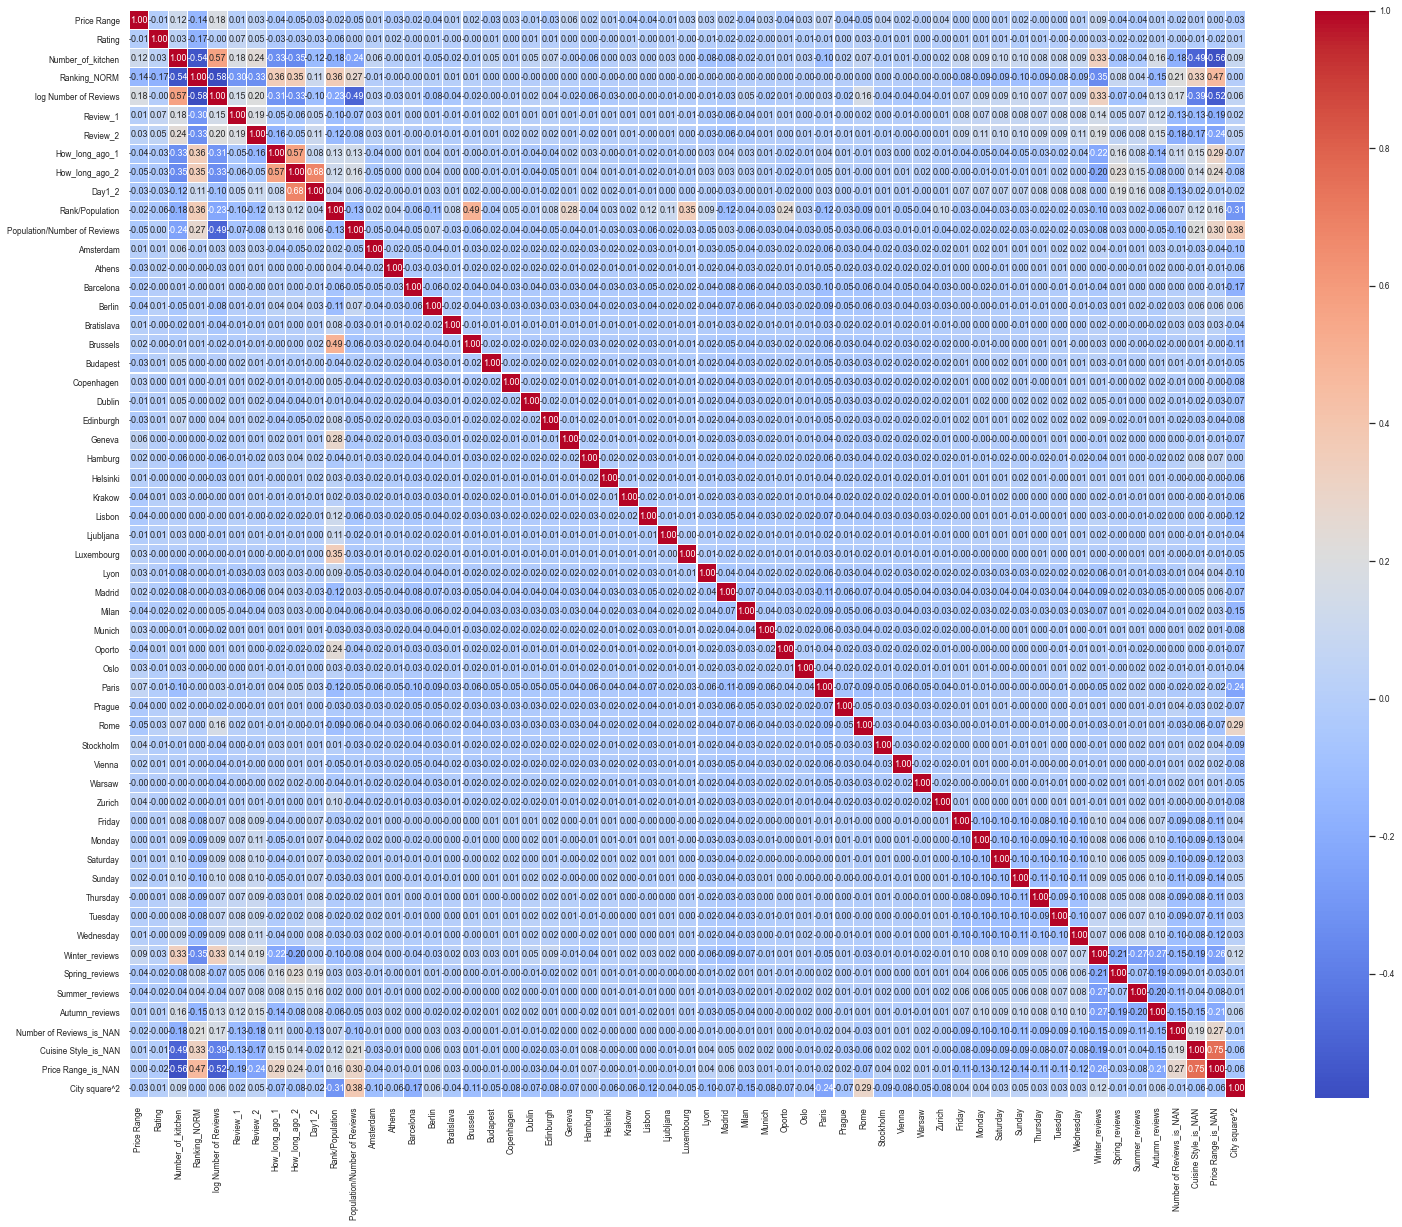

In [55]:
sns.set(font_scale=0.75)
plt.subplots(figsize=(25, 20))
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

Нельзя выделить признаки, которые явно связаны с целевой переменной Rating. Между собой признаки так же сильно не коррелируются.  Поэтому все признаки будут использованы при моделировании.

# Обучение модели

In [56]:
# Теперь выделим датасет для обучения
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values              # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 58), (40000, 58), (40000, 57), (32000, 57), (8000, 57))

In [57]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ, заданы условиями соревнования)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [58]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [59]:
# Округлим до 0.5 полученные значения рейтинга
y_pred = (y_pred * 2).round()/2
y_pred

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1620625


<AxesSubplot:>

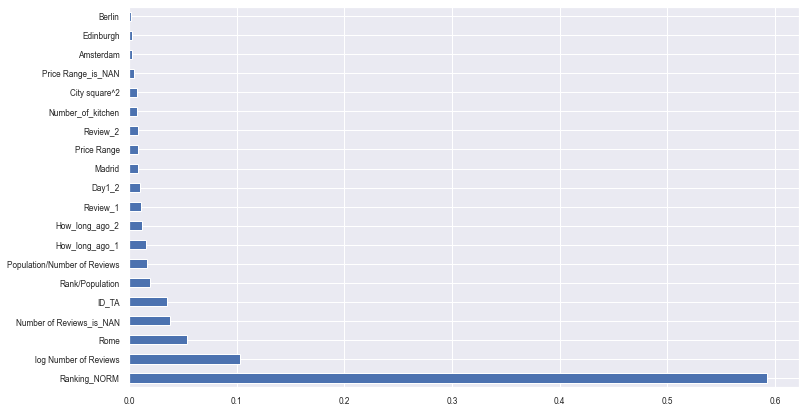

In [67]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12, 7)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission

Все устраивает - готовим Submission на кагл

In [62]:
test_data.sample(10)

,Price Range,ID_TA,Rating,Number_of_kitchen,Ranking_NORM,log Number of Reviews,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Rank/Population,Population/Number of Reviews,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Сity square^2
8116,1.90,1331367,0.0,1,0.454239,3.891820,1.000000,0.00,2943.0,1578.0,0.0,0.000898,10.541667,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,2.291537e+03
4689,2.00,742660,0.0,4,0.268911,4.976734,0.700000,0.10,1335.0,1362.0,27.0,0.000183,10.215278,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,9.654070e+04
2527,2.00,8727928,0.0,2,0.589155,4.663439,0.700000,0.80,1344.0,1216.0,128.0,0.003291,1.704762,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1.063412e+03
6321,1.74,1357805,0.0,1,0.940207,1.386294,-0.250000,0.00,3930.0,1578.0,0.0,0.000258,1214.666667,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,7.950932e+05
8013,3.00,12240595,0.0,2,0.585884,1.098612,0.695312,0.00,1544.0,1578.0,0.0,0.001369,214.000000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,8.441934e+03
5185,1.85,12322378,0.0,1,0.995232,4.615121,0.000000,0.00,1510.0,1578.0,0.0,0.000305,32.660000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3.684490e+05
7904,1.85,10353371,0.0,1,0.960381,2.397895,0.000000,0.00,1510.0,1578.0,0.0,0.000294,326.600000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3.684490e+05
5953,1.74,1342395,0.0,1,0.978970,1.609438,-1.000000,0.25,2134.0,3218.0,1084.0,0.000269,911.000000,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,1,1,7.950932e+05
8161,2.00,8602902,0.0,5,0.253110,4.060443,1.000000,1.00,1357.0,1370.0,13.0,0.000118,37.684211,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,1.110916e+04
7292,2.00,9786186,0.0,2,0.491000,2.708050,0.000000,0.60,1475.0,1354.0,121.0,0.000055,636.285714,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,2.471184e+06


In [63]:
test_data = test_data.drop(['Rating'], axis=1)

In [64]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [65]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


array([3. , 4.5, 4. , ..., 3. , 4.5, 4.5])

In [66]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# Итоги и выводы

Изначальный датасет содержал 9 признаков и одну целевую переменную. На основании только этих данных MAE для модели была равна 0.425.


Была проделана огромная работа по подготовке данных для обучения модели. 
- Совсем неинформативные признаки были удалены;
- Все пропущенные значения в колонках были заполнены, часть выбросов исправлена;
- Некоторые числовые признаки были логарифмированы, для уменьшения количества выбросов и "более нормальной" картины распределения;
- Были созданы dummy-признаки из категориальных;
- Колонка со сложной структурой (Reviews) была разбита на несколько, с каждой из который далее была проделана работа по созданию новых признаков;
- При Feature Engineering использовались абсолютно разные методы для создания новых признаков (dummy и полиномиальные признаки, новая информация взятая из открытых источников, разные математические операции между колонками, создания колонок, отмечающих места пропусков, создание признаков с помощью сторонних библиотек и т.д.)
- Были отобраны наиболее значимые признаки и с ним уже была проведене ML

В результате EDA и Feature Engineering MAE для изначальной модели изменилось до 0.162. 

На [странице соревнования](https://www.kaggle.com/c/sf-dst-restaurant-rating/leaderboard) работа входит в 8% лучших, что на мой взгляд великолепный результат, поскольку лидербор не коррелируется создателями соревнования (первые модели явно переобучены, в других использовались более сложные модели для улучшения результатов, хотя по условию менять модель нельзя)  